## Download the Data

#### Once you have signed up and agreed to the license terms for the data set please download the data by browsing to the link below. N.B. it is the 300x300 images that are used, not the 512x512 images.

https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product?select=casting_data

## Import Tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## Image Metadata

In [3]:
color_mode = "grayscale"
number_colour_layers = 1
image_size = (300, 300)
image_shape = image_size + (number_colour_layers,)

## Import & Preprocess the Data

In [9]:
training_data_path = "/Users/timbusfield/Downloads/archive (1)/casting_data/casting_data/train"
test_data_path = "/Users/timbusfield/Downloads/archive (1)/casting_data/casting_data/test"
SEED = 42

In [10]:
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )

In [11]:
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    return raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
    )

In [12]:
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [13]:
training_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "training"
)
validation_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "validation"
)
test_ds = get_image_data(
    test_data_path,
    color_mode,
    image_size
)

Found 6633 files belonging to 2 classes.
Using 5307 files for training.
Found 6633 files belonging to 2 classes.
Using 1326 files for validation.
Found 715 files belonging to 2 classes.


### Class Sanity Check

In [16]:
equivalence_check = training_ds["classNames"] == validation_ds["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = training_ds["classNames"]
number_classes = len(class_names)

### Review Image Samples

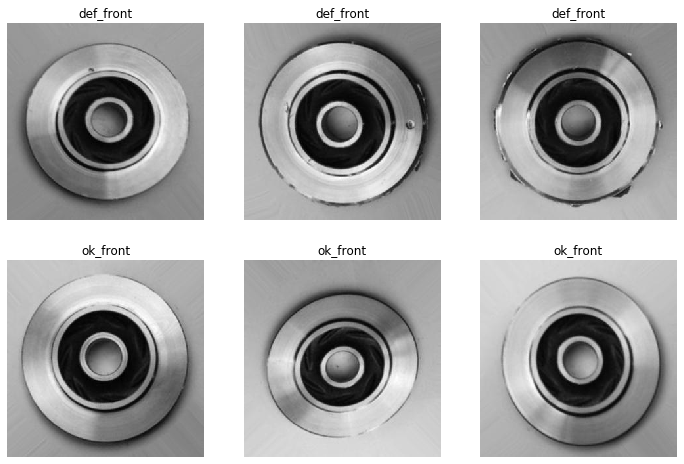

In [17]:
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
image_indexes = [286, 723, 1103]
selected_image_file_paths = dict()
for classification in class_names:
    image_directory = join(training_data_path, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]
plt.figure(figsize=(12, 8))
    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,3,image_number)
        plt.title(classification)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))

## Model Definition

In [32]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

In [33]:
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

In [34]:
core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

In [35]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

In [36]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

In [37]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

## Training the Model

In [38]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
history = model.fit(
    training_ds["data"],
    validation_data = validation_ds["data"],
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20
166/166 [==============================] - 114s 686ms/step - loss: 0.5385 - accuracy: 0.7228 - val_loss: 0.4662 - val_accuracy: 0.7421
Epoch 2/20
166/166 [==============================] - 115s 696ms/step - loss: 0.3248 - accuracy: 0.8532 - val_loss: 0.2681 - val_accuracy: 0.8989
Epoch 3/20
166/166 [==============================] - 106s 641ms/step - loss: 0.2637 - accuracy: 0.8798 - val_loss: 0.2352 - val_accuracy: 0.9148
Epoch 4/20
166/166 [==============================] - 110s 660ms/step - loss: 0.2191 - accuracy: 0.9052 - val_loss: 0.2014 - val_accuracy: 0.9193
Epoch 5/20
166/166 [==============================] - 105s 631ms/step - loss: 0.1812 - accuracy: 0.9282 - val_loss: 0.1508 - val_accuracy: 0.9532
Epoch 6/20
166/166 [==============================] - 102s 616ms/step - loss: 0.1194 - accuracy: 0.9591 - val_loss: 0.1145 - val_accuracy: 0.9668
Epoch 7/20
166/166 [==============================] - 111s 666ms/step - loss: 0.0963 - accuracy: 0.9685 - val_loss: 0.0982 -

## Evaluate the Model & Training

In [43]:
model.evaluate(test_ds["data"])

23/23 [==============================] - 4s 164ms/step - loss: 0.0177 - accuracy: 0.9916


[0.017749927937984467, 0.9916083812713623]

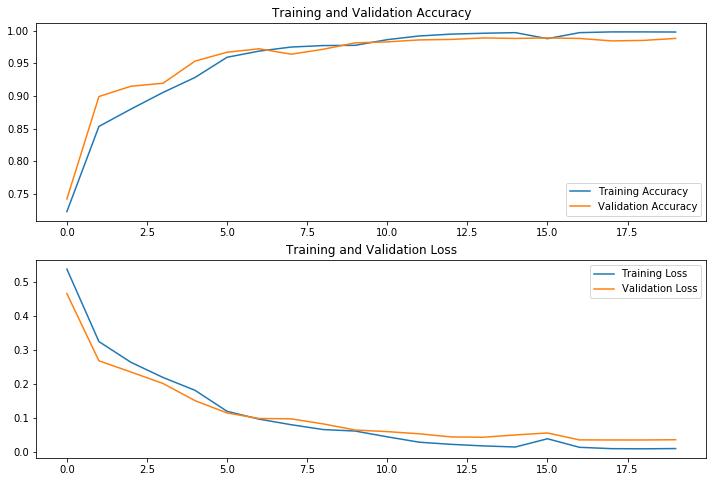

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the Model - TensorFlow.js

In [46]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(
    model,
    "./tmp/model_js_1"
)

/Applications/anaconda/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
